# The Fairness of Fair Market Rent

*Project Members: Mack McGlenn, Corey Baughman, Aaron Moore, Adriana Nuncio*

## Imports

In [1]:
# import wrangle functions
from wrangle_final import (wrangle_metro_data,
                           wrangle_zipcode_data)
# import explore functions
from explore import (get_disparity_graph, 
                    get_target_hist,
                    get_trend_line_plot,
                    get_difference_by_month_bar,
                    get_avg_diff_6m,
                    get_affordability_map,
                    get_min_max_comparison)
# import modeling functions
from model import (get_baseline_table,
                  get_models,
                  get_all_models,
                  get_test)

import matplotlib.pyplot as plt 
import seaborn as sns

## Acquire

*U.S. Department of Housing and Urban Development (HUD) Fair Market Rent (FMR) Metropolitan Area Acquisiton*
* The HUD FMR data was downloaded as a csv file from [HUD User Portal History](https://www.huduser.gov/portal/datasets/fmr.html#history).
    * Note: "Fair Market Rents, as defined in 24 CFR 888.113 are estimates of 40th percentile gross rents for standard quality units within a metropolitan area or nonmetropolitan county."
* The csv file was acquired on 31 May 2023
* After filtering to entity id, two-bedrooms, and years 2017-2023, there were 75 row and 4 columns.
* Each row (observation) represents a month between January 2017 and March 2023.

*Median Market Rent (MMR) Acquisition*
* The MMR data was downloaded from [BiggerPockets](https://www.biggerpockets.com/files/user/leahd42/file/webinar-bonus-2022-rental-data). 
* There were intitial challenges due to the excel file having merged cells. These cells were unmerged and the new spreadsheet was saved as a csv. This process was completed in the spreadsheet and not in the jupyter notebook. Due to this, the csv file is available in the github repository.
* The Market Rent data was acquired from BiggerPockets, a media company and social network focused on commercial and residential real estate investing. This particular dataset was created by Kaylin Cooper, an investor who has been tracking market trends in the top 100 cities in the U.S. since 2017.
* Each row represented the median market rent at a specific point in time for a rental with a specified number of bedrooms.
* Each column represented supplementary information about the rental properties 
* Size at Acquisition: 300 rows x 77 columns 

*HUD FMR Zip Code Acquisiton*
* The HUD FMR Zip Code data was acuired using the [HUD User API](https://www.huduser.gov/portal/dataset/fmr-api.html)
* The data was last acquired on 07 June 2023
* Only data within the San Antonio/New Braunfels, TX Metropolitan Area as defined by the [Office of Management and Budget (OMB)](https://www.federalregister.gov/documents/2021/07/16/2021-15159/2020-standards-for-delineating-core-based-statistical-areas) in 2020 was acquired.
* The data had 812 observations and 7 columns
* Each observation represents the FMR rates in a given zip code and year, with each column representing the price based on the number of bedrooms

*Market Rent by Zip Code Acquisition*
* The market rent by zip code was acquired from Realty Mole via [Rapid API](https://rapidapi.com/realtymole/api/realty-mole-property-api).
* This data is available as a csv in the GitHub repository due to the paywall associated with Rapid API after 50 pulls.
* There are 139 zip codes in the San Antonio/New Braunfels, TX Metropolitan Area. Two team members requested 50 of the zip codes and one team requested 39. Each team member saved their pull as a csv which were merged into one final messy csv. 
* The combined csv had 3 rows and 108 columns. Two rows were the zip code and the final row was the rental data held in a dictionary. Each column represented one zip code.

*Zip Code Tabulation Area (ZCTA) Acquisition*
* The ZCTA data was downloaded from [Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.html).
* The initial file was over 1 GB in size, containing data on every ZCTA in the United States
* Each row represented one ZCTA with each column a different feature about the ZCTA such as land mass and geometry.
* Due to the large size of the intial file, the reduced csv file with only the zip codes of interest will be available in the GitHub Repository.


## Prepare

*HUD Metro FMR Preparation*
* Filter rows to only those in our entity_id 
* Chose columns for two bedroom FMRs in years 2017-2023
* Reassign column names as years and transpose to make years rows 
* Group counties sharing the same entity_id into a single value for the entity 
* Resample the annual rates to monthly rates to align with 3rd party data frequency
* Time shift the monthly rates to line up with the federal fiscal year
* There were no null values in the HUD data
* There were no significant outliers and we chose to keep all data points

*MMR Preparation*
* Set the dates as the index for the dataframe
* Isolate the market rent for the San Antonio market
* Keep only the values for 2 bedroom units

*HUD FMR and MMR Metro Wrangle*
* The FMR index was converted to datetime
* Both datasets were merged on the datetimeindex
* The FMR column had null values that were replaced with the correct FMR amount
* The MMR column had null values were dropeed because no data was available
* One column was created representing the difference between the MMR column and the FMR column
* Lastly, the dataframe was split using human-based splitting, with the test data contain the last 12 months of the data, validate containing 24 months of data, and the train data containing all data from before that cutoff. 

*HUD FMR Zip Code Preparation*
* The index was set to datetime
* The data was resampled to monthly
* A 3 month shift was applied to match the federal fiscal calendar which begins in October od each year
    * The shift created missing data points. This data was forward filled becasue the HUD FMR rates only change once a year.
    
*Market Rent by Zip Code Preparation*
* The rental data column contained a dictionary with all the pertinent information about each zip code.
* The index was set to datetime
* The bedrooms were filtered to only include 2 bedroom prices
* Lastly, unnecessary columns were dropped

*Zip Code Data Wrangle*
* The HUD FMR zip code data and market rent zip code data was inner joined/merged using the date and zipcode
* New columns were formed to create an affordability scale

*ZCTA Preparation*
* Changed one column name to zip_code
* Dropped all columns except zip_code and geometry

*GeoDataFrame Wrangle*
* Both the GeoDataFrame and the wrangled zipcode data were used
* Filtered the wrnagled zipcode data to only '2023-05' with columns of interest (zip code, affordability, and number of properties available)
* Joined both datasets using the zip codes
* Set the index to zip codes

In [24]:
# wrangling metro data (exploration and modeling data)
df, train, validate, test = wrangle_metro_data()

# wrangling zipcode data (exploration data)
zip_code_df = wrangle_zipcode_data()

## Explore

### 1. How have the HUD Fair Market Rent Voucher (FMR) and Median Market Rent (MMR) amounts changed over time?
*Note: Henceforth, the HUD Fair Market will be referred to as FMR.*

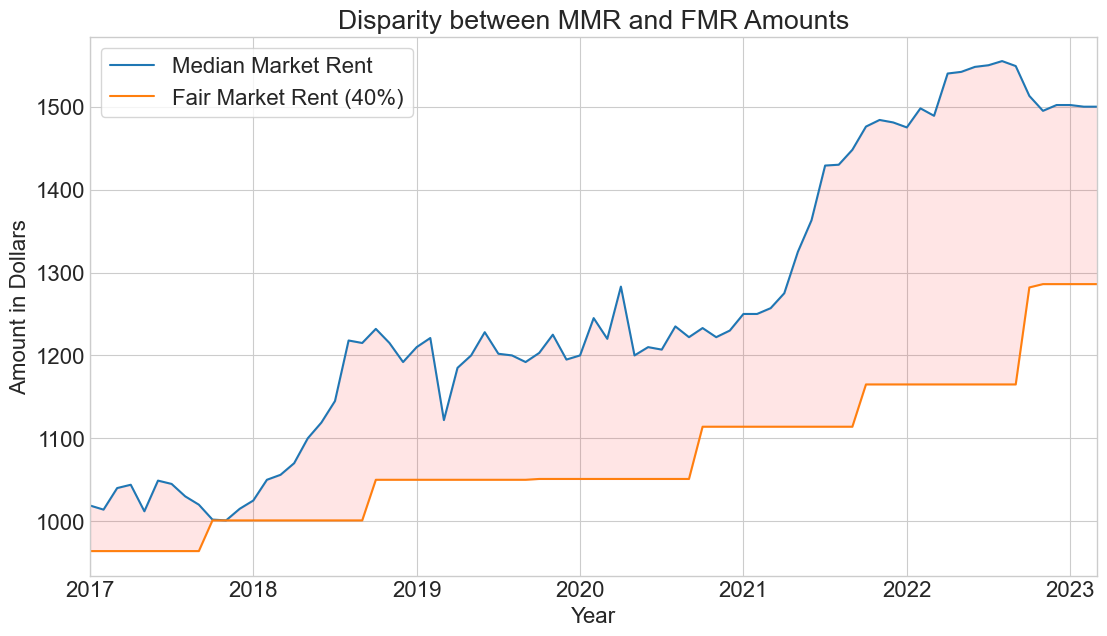

In [3]:
# get visual
get_disparity_graph()

#### Takeaways:
* Since October of 2017, the FMR amount has not been the same as the the MMR. 
* Both increase over time, with MMR having more volaitility.
    * New FMR amounts are applied in October in alginment with the federal fiscal year. No other adjustments are made which is evident in the chart.
* While the FMR adjusts once a year, it appears that it is not adjusting fast enough.

### 2. What is the distribution of our the difference between FMR and MMR?

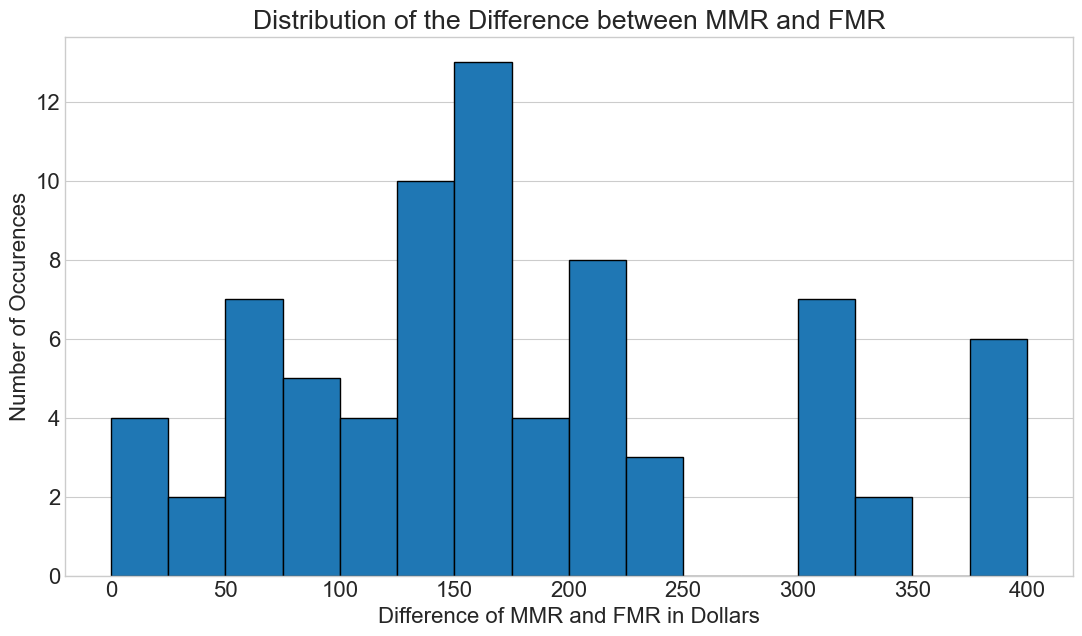

In [4]:
# get visual
get_target_hist()

#### Takeaways:
* The difference is often between \\$125 and \\$175 dollars
* There are many instances where the difference is greater than \\$200. Realistically, individuals who are using FMR vouchers will not have the financial resources to afford that price difference.

### 3. What do the price differences look like over time?

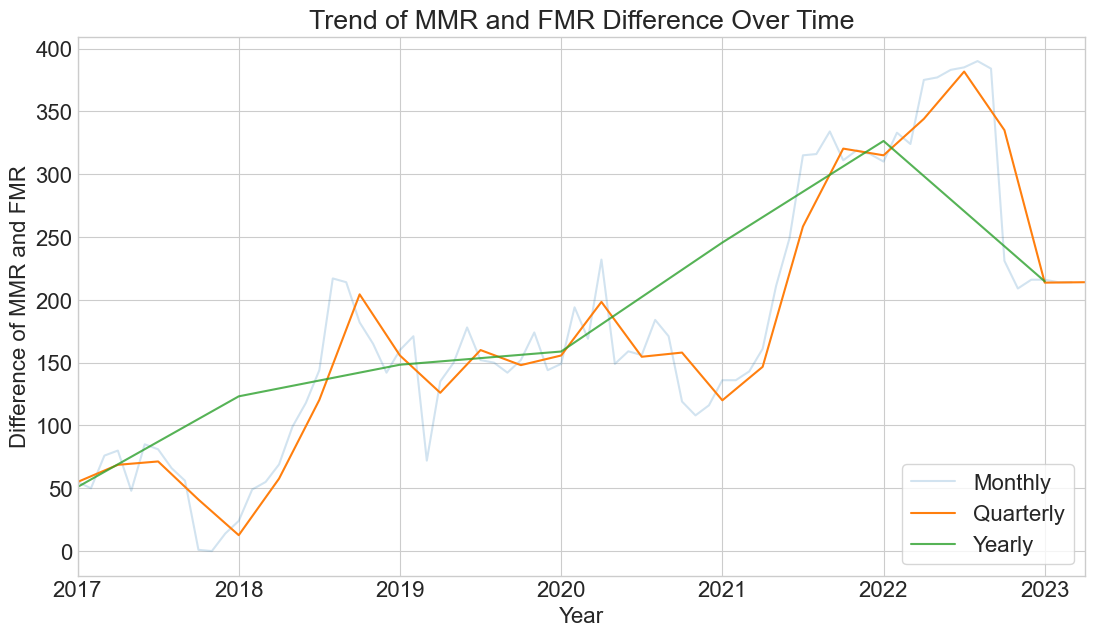

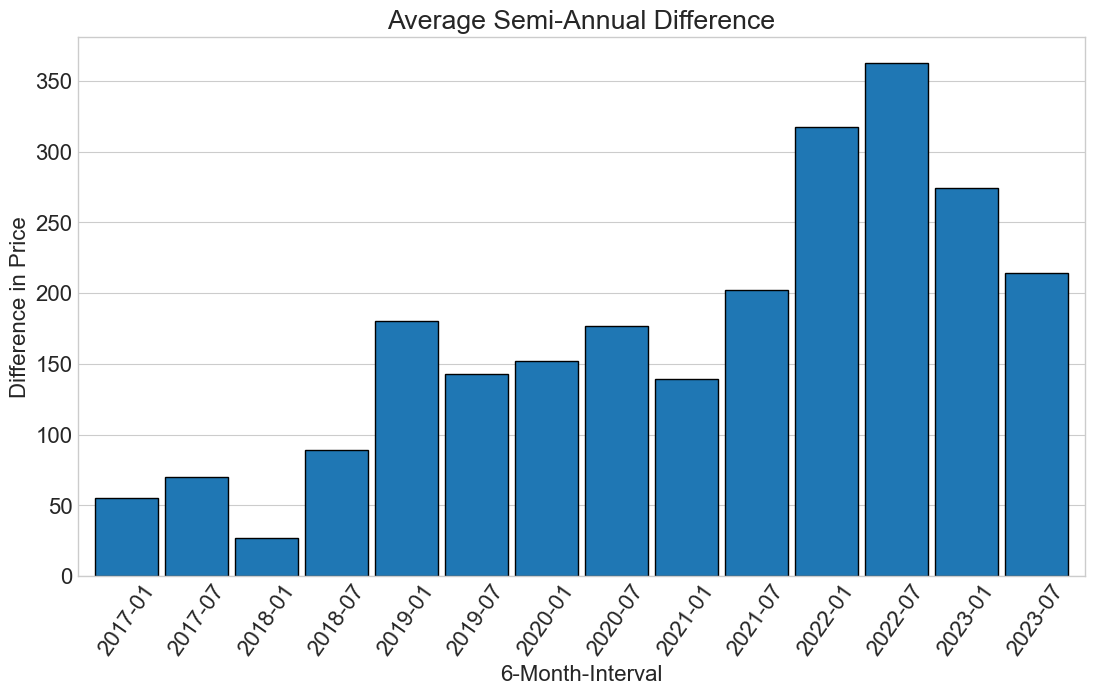

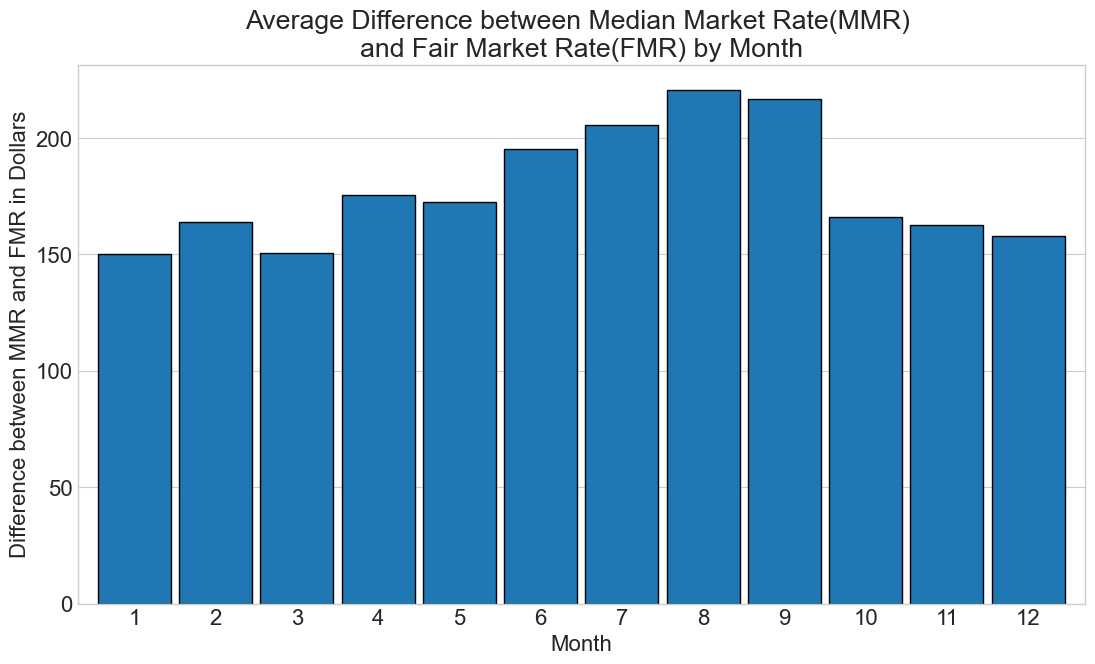

In [5]:
# get visuals
get_trend_line_plot()
get_avg_diff_6m()
get_difference_by_month_bar()

#### Takeaways:
* *Trend of MMR and FMR Difference over time*
    * From 2017 to 2018, there is a small difference between FMR and MMR, with a swift rise in 2018.
    * The FMR adjustments stabilized the difference from 2019 to 2021, but this stabilization did not reduce the difference back to its 2017/18 state. 
    * A sharp increase occurred from 2021 to until October of 2022. This may be a replication of what occured from 2018 to 2020, with the increase followed by stabilization in difference. More time and data is needed to see how the difference continues to change.
* *Average Semi-Annual Difference*
    * This graph supports the findings in the first graph, with an emphasis on the magnitude of the change in difference.
    * The increase in 2021 was more drastic than the increase in 2018. This is likely due to COVID-19 and the rising inflation that came with it. 
* *Average Difference between MMR and FMR by Month*
    * This bar graph presents the volatility of the monthly difference with an aggregated view. 
    * Unsurpisingly, the average difference drops in October, when the FMR adjustments are applied.
    * This indicates from October to March, FMR vouchers will have the most use, but individuals and families using vouchers may not have the liberty of waiting until these prime months to move into housing. 
    * After march, we steady increases in the difference between MMR and FMR. This increase likely causes hardhsip for individuals looking for housing with HUD vouchers during the summer months.

### 4. When has difference been the highest? Lowest?

### 4. How does affordability change with the difference?

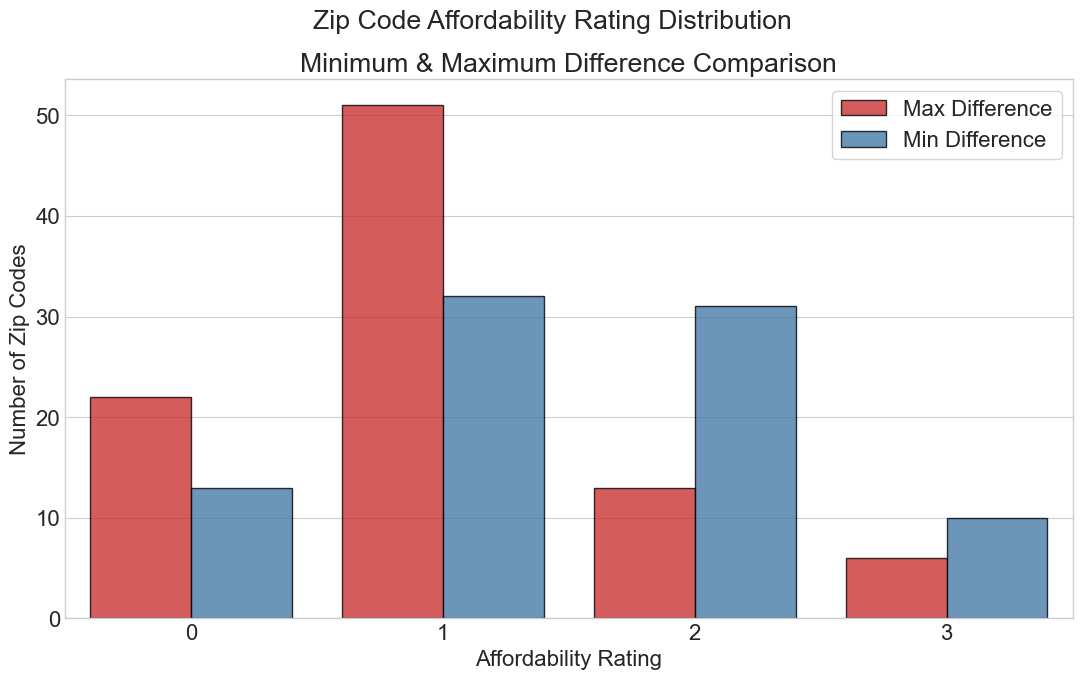

<Figure size 1300x700 with 0 Axes>

In [3]:
# getting gropah comparing min and max difference moments
get_min_max_comparison()
plt.savefig('min_max_compare.jpg')

## Exploration Summary
##### Takeaways:
* There has been a steady increase in the difference between MMR and FMR, with occasioanal decreases in the difference occurring in October, when the FMR voucher amount is adjusted. 
* The best time to use a voucher is between October and March.

##### Features:
* Modeling will be done on all features in the dataset, with a focus on the difference.


## Modeling

### Introduction
* Root Mean Squared Error will be used as the evaluation metric for its applicability to continuous variables/
* While the difference is the target, we will also be modeling and predicting MMR and FMR due to the difference being reliant on both.
* The best performing baseline was the 1-month rolling average. 

In [13]:
# get baseline table
get_baseline_table()

,model_type,target_var,rmse
0,1_month_rolling_average,fmr,72.0
0,1_month_rolling_average,mmr,158.0
0,1_month_rolling_average,diff,98.0
0,1_month_rolling_average,percent_diff,8.0


### Model Validation
* Only two models provided useful predictions, Holts Linear Trend with optimization and Holts Seasonal Trend (ExponentialSmoothing) with a seasonal period of 12 months, additive seasonality, additive overall trend, and damped hyperparameters set.
* When comparing to baseline predicitons, both models outperform the baseline, with Holt' Seasonal Trend performing the best. We will continuw on with Holt's Seasonal Trend into testing.

In [14]:
# get models
get_all_models()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provid

,model_type,target_var,rmse
0,1_month_rolling_average,fmr,72.0
1,1_month_rolling_average,mmr,158.0
2,1_month_rolling_average,diff,98.0
3,1_month_rolling_average,percent_diff,8.0
4,holts_optimized,fmr,53.0
5,holts_optimized,mmr,99.0
6,holts_optimized,diff,71.0
7,holts_optimized,percent_diff,6.0
8,holts_seasonal,fmr,56.0
9,holts_seasonal,mmr,87.0


### Test Model
* There is a large increase in the RMSE for both the baseline and the Holt's Seasonal Trend model. 
* Despite increases in RMSE, the Holt's Seasonal Trend model still outperformed the baseline with for all target variables. 

In [15]:
# getting baseline and gholts seasonsal test metrics
get_test()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,model_type,target_var,rmse
0,1_month_rolling_average,fmr,184.0
1,1_month_rolling_average,mmr,306.0
2,1_month_rolling_average,diff,155.0
3,1_month_rolling_average,percent_diff,12.0
4,holts_seasonal,fmr,157.0
5,holts_seasonal,mmr,137.0
6,holts_seasonal,diff,80.0
7,holts_seasonal,percent_diff,7.0


### Modeling Wrap 
* The increase in RMSE can be explained by the swift increase in MMR in 2021, followed by a larger than usual increase to the FMR that occurs in 2022. Both of these increases were not in the training data, meaning the model was not trained on the swift and large increases that occured for both MMR and FMR. 
* As of right now, this model has more use than using nothing or the best baseline. This can be used for rough prediction, but the demographic using HUD FMR vouchers likely do not have enough disposable income to account for predictions with RMSEs this high. I do not recommend this top be used by consumers, but rather as an rough estimation tool within HUD.

## Conclusion

### Summary
* There has been a steady increase in the difference between MMR and FMR, with occasioanal decreases in the difference occurring in October, when the FMR voucher amount is adjusted. 
* The best time to use a voucher is between October and March. 
* Modeling was successful when using the baseline RMSE as a benchmark, but we do not believe it has a low enough RMSE to be useful for consumers.

### Recommendations
* There is an adjustment period of 1 year that the FMR takes to account for changes in the market. We recommend doing semi-annual adjustments, with October being the official adjustment and March holding a preliminary adjustment. This recommendation is based on the average shift in difference between March and October.

### Next Steps
* Acquire MMR data from before 2017
* Acquire and explore more locations
* Take a granular look into zip code level data instead of MSA
